# Proving Neyman Orthogonality 

We start with the standard linear model formulation:

$$
Y = \alpha D + \beta' W + \epsilon
$$

Where:
- $\alpha$ is the coefficient of interest linked to the treatment variable $D$.
- $\beta$ is a vector of coefficients associated with the control variables $W$.
- $\epsilon$ is the error term.

The residuals from Lasso regressions:
- For the outcome $Y$ on controls $W$, let the estimate be $\gamma_{YW}'$.
- For the treatment $D$ on controls $W$, let the estimate be $\gamma_{DW}'$.

The residuals are defined as:
$$
\tilde{Y} = Y - \gamma_{YW}'W
$$
$$
\tilde{D} = D - \gamma_{DW}'W
$$

We define the true parameter vector:
$$
\eta^0 = (\gamma_{DW}', \gamma_{YW}')'
$$

Since $\alpha$ is a function of $\eta$, where $\eta = (\eta_1', \eta_2')'$, we aim to show that $\alpha$ is insensitive to local perturbations around $\eta^0$:
$$
D = \frac{\partial \alpha(\eta^0)}{\partial \eta} = 0
$$

### Proposed Model

We assume the model:
$$
\tilde{Y} = a \tilde{D} + \mu
$$
Where $\alpha = \arg\min_{a \in \mathbb{R}} E[(\tilde{Y} - a \tilde{D})^2]$. $\alpha$ is the true value as it minimizes the expected square residuals.

The moment condition for the model is:
$$
M(a, \eta) = E[(\tilde{Y}(\eta_1) - a \tilde{D}(\eta_2)) \tilde{D}(\eta_2)]
$$
Where:
$$
\tilde{Y}(\eta_1) = Y - \eta_1'W
$$
$$
\tilde{D}(\eta_2) = D - \eta_2'W
$$

At true values $\eta = \eta^0$:
$$
\tilde{Y} = Y - \gamma_{YW}'W
$$
$$
\tilde{D} = D - \gamma_{DW}'W
$$

### Application of the Implicit Function Theorem

To derive $a$ with respect to $\eta$:
$$
\frac{\partial a}{\partial \eta} = -\partial_a M(\alpha, \eta^0)^{-1} \partial_\eta M(\alpha, \eta^0)
$$
To demonstrate $\frac{\partial \alpha(\eta^0)}{\partial \eta} = 0$, we need $\partial_\eta M(\alpha, \eta^0)$ to be zero since $\partial_a M(\alpha, \eta^0)$ cannot be zero.

### Derivatives Calculation

For the first component:
$$
\frac{\partial M(\alpha, \eta^0)}{\partial \eta_1} = E\left[\frac{\partial \tilde{Y}(\eta_1)}{\partial \eta_1} \tilde{D}\right]
$$
Given that $\tilde{Y} = Y - \eta_1'W$:
$$
\frac{\partial \tilde{Y}}{\partial \eta_1} = -W
$$
Thus:
$$
\frac{\partial M(\alpha, \eta^0)}{\partial \eta_1} = E[-W \tilde{D}] = 0
$$

For the second component:
$$
\frac{\partial M(\alpha, \eta^0)}{\partial \eta_2} = E\left[(-a \frac{\partial \tilde{D}(\eta_2)}{\partial \eta_2})\tilde{D} + \frac{\partial \tilde{D}(\eta_2)}{\partial \eta_2}(\tilde{Y} - a\tilde{D})\right]
$$
Since $\tilde{D} = D - \eta_2'W$:
$$
\frac{\partial \tilde{D}}{\partial \eta_2} = -W
$$
Resulting in:
$$
\frac{\partial M(\alpha, \eta^0)}{\partial \eta_2} = -E[W\tilde{Y}] + 2E(\alpha W\tilde{D}) = 0
$$

This confirms that $\frac{\partial M}{\partial \eta_1} = 0$ and $\frac{\partial M}{\partial \eta_2} = 0$. Therefore, $\frac{\partial \alpha(\eta^0)}{\partial \eta} = 0$ is proven.


# Simulation Design

In [2]:
# import Pkg

# Pkg.add("CovarianceMatrices")

In [3]:
using Distributions
using DataFrames
using CSV
using Tables
using GLM
using CovarianceMatrices

using Gadfly

In [4]:
using Random
Random.seed!(1234)

TaskLocalRNG()

In [5]:
#importamos hdmjl
#include("../Julia_Notebooks/hdmjl/hdmjl.jl")
include("C:/Users/VICTOR/Documents/GitHub/CausalAI-Course/labs/julia_notebooks/hdmjl/hdmjl.jl")

$X = []_{1000*100}$ \
$D = \gamma*X + e_1$ \
$ Y = 5*D + \beta*X + e_2$

# Simulation Design 1

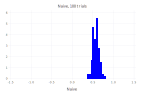

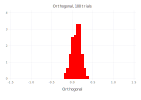

In [6]:
B = 100
Naive = zeros(B)
Orthogonal = zeros(B)

for i in 1:B
    n = 1000
    p = 100
    beta = 1 ./ (1:p).^2
    gamma = 1 ./ (1:p).^2

    X = rand(Normal(0,1),n,p)
    D = X * (gamma) + (rand(Normal(0,1),n,1)/4)
    Y = 10*D + X * (beta) + rand(Normal(0,1),n,1)
    
    X = DataFrame(X, :auto)
    D = DataFrame(D, ["D"])
    X1 = hcat(D,X)

    Y = DataFrame(Y, ["Y"])
    
    ## NAIVE
    model1=rlasso_arg( X1, Y ,nothing, true, true, true, false, false, 
                    nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, false, Inf, true )
    
    coef1 = rlasso(model1)["coefficients"][3:102,2]
    SX_IDs = findall(rlasso(model1)["coefficients"][3:102,2] .!= 0 )

    if (sum(coef1[SX_IDs,:])==0) 
        Y1 = hcat(Y,D)
        Naive[i] = coef(lm(@formula(Y ~ D), Y1))[2] - 10
    end

    if (sum(coef1[SX_IDs,:])>0) 
        Xi = DataFrame(X[:,SX_IDs])
        Y2 = hcat(Y,D,Xi)
        Naive[i] = coef(lm(@formula(Y ~ D + x1 ), Y2))[2] - 10
    end

    ## ORTHOGONAL LEARNING
    model2 =rlasso_arg( X, Y ,nothing, false, true, true, false, false, 
                        nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )
    model3 =rlasso_arg( X, D ,nothing, false, true, true, false, false, 
                        nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )

    resY = rlasso(model2)["residuals"]
    resD = rlasso(model3)["residuals"]
    Y3=DataFrame(hcat(resY,resD),["resY","resD"])
    Orthogonal[i]= coef(lm(@formula(resY ~ resD), Y3))[2] - 10

end


results = DataFrame(hcat(Naive,Orthogonal),["Naive","Orthogonal"])

display(Gadfly.plot(results, Coord.cartesian(xmin=-1.5, xmax=1.5),
    layer(x = "Naive", Geom.histogram(bincount=10, density=true),
    color=[colorant"blue"]),
    Guide.title("Naive, 100 trials")
))

display(Gadfly.plot(results, Coord.cartesian(xmin=-1.5, xmax=1.5),
    layer(x = "Orthogonal", Geom.histogram(bincount=10, density=true),
    color=[colorant"red"]),
    Guide.title("Orthogonal, 100 trials")
))

# Simulation Design 2

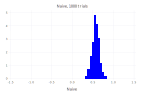

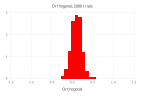

In [8]:
B = 1000
Naive = zeros(B)
Orthogonal = zeros(B)

for i in 1:B
    n = 1000
    p = 100
    beta = 1 ./ (1:p).^2
    gamma = 1 ./ (1:p).^2

    X = rand(Normal(0,1),n,p)
    D = X * (gamma) + (rand(Normal(0,1),n,1)/4)
    Y = 10*D + X * (beta) + rand(Normal(0,1),n,1)
    
    X = DataFrame(X, :auto)
    D = DataFrame(D, ["D"])
    X1 = hcat(D,X)

    Y = DataFrame(Y, ["Y"])
    
    ## NAIVE
    model1=rlasso_arg( X1, Y ,nothing, true, true, true, false, false, 
                    nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, false, Inf, true )
    
    coef1 = rlasso(model1)["coefficients"][3:102,2]
    SX_IDs = findall(rlasso(model1)["coefficients"][3:102,2] .!= 0 )

    if (sum(coef1[SX_IDs,:])==0) 
        Y1 = hcat(Y,D)
        Naive[i] = coef(lm(@formula(Y ~ D), Y1))[2] - 10
    end

    if (sum(coef1[SX_IDs,:])>0) 
        Xi = DataFrame(X[:,SX_IDs])
        Y2 = hcat(Y,D,Xi)
        Naive[i] = coef(lm(@formula(Y ~ D + x1 ), Y2))[2] - 10
    end

    ## ORTHOGONAL LEARNING
    model2 =rlasso_arg( X, Y ,nothing, false, true, true, false, false, 
                        nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )
    model3 =rlasso_arg( X, D ,nothing, false, true, true, false, false, 
                        nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )

    resY = rlasso(model2)["residuals"]
    resD = rlasso(model3)["residuals"]
    Y3=DataFrame(hcat(resY,resD),["resY","resD"])
    Orthogonal[i]= coef(lm(@formula(resY ~ resD), Y3))[2] - 10

end


results = DataFrame(hcat(Naive,Orthogonal),["Naive","Orthogonal"])

display(Gadfly.plot(results, Coord.cartesian(xmin=-1.5, xmax=1.5),
    layer(x = "Naive", Geom.histogram(bincount=10, density=true),
    color=[colorant"blue"]),
    Guide.title("Naive, 1000 trials")
))

display(Gadfly.plot(results, Coord.cartesian(xmin=-1.5, xmax=1.5),
    layer(x = "Orthogonal", Geom.histogram(bincount=10, density=true),
    color=[colorant"red"]),
    Guide.title("Orthogonal, 1000 trials")
))

# Simulation Design 3

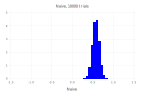

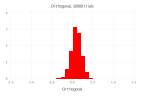

In [56]:
B = 10000
Naive = zeros(B)
Orthogonal = zeros(B)

for i in 1:B
    n = 1000
    p = 100
    beta = 1 ./ (1:p).^2
    gamma = 1 ./ (1:p).^2

    X = rand(Normal(0,1),n,p)
    D = X * (gamma) + (rand(Normal(0,1),n,1)/4)
    Y = 10*D + X * (beta) + rand(Normal(0,1),n,1)
    
    X = DataFrame(X, :auto)
    D = DataFrame(D, ["D"])
    X1 = hcat(D,X)

    Y = DataFrame(Y, ["Y"])
    
    ## NAIVE
    model1=rlasso_arg( X1, Y ,nothing, true, true, true, false, false, 
                    nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, false, Inf, true )
    
    coef1 = rlasso(model1)["coefficients"][3:102,2]
    SX_IDs = findall(rlasso(model1)["coefficients"][3:102,2] .!= 0 )

    if (sum(coef1[SX_IDs,:])==0) 
        Y1 = hcat(Y,D)
        Naive[i] = coef(lm(@formula(Y ~ D), Y1))[2] - 10
    end

    if (sum(coef1[SX_IDs,:])>0) 
        Xi = DataFrame(X[:,SX_IDs])
        Y2 = hcat(Y,D,Xi)
        Naive[i] = coef(lm(@formula(Y ~ D + x1 ), Y2))[2] - 10
    end

    ## ORTHOGONAL LEARNING
    model2 =rlasso_arg( X, Y ,nothing, false, true, true, false, false, 
                        nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )
    model3 =rlasso_arg( X, D ,nothing, false, true, true, false, false, 
                        nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )

    resY = rlasso(model2)["residuals"]
    resD = rlasso(model3)["residuals"]
    Y3=DataFrame(hcat(resY,resD),["resY","resD"])
    Orthogonal[i]= coef(lm(@formula(resY ~ resD), Y3))[2] - 10

end


results = DataFrame(hcat(Naive,Orthogonal),["Naive","Orthogonal"])

display(Gadfly.plot(results, Coord.cartesian(xmin=-1.5, xmax=1.5),
    layer(x = "Naive", Geom.histogram(bincount=10, density=true),
    color=[colorant"blue"]),
    Guide.title("Naive, 10000 trials")
))

display(Gadfly.plot(results, Coord.cartesian(xmin=-1.5, xmax=1.5),
    layer(x = "Orthogonal", Geom.histogram(bincount=10, density=true),
    color=[colorant"red"]),
    Guide.title("Orthogonal, 10000 trials")
))

# Interpretation

The distribution of the histograms is different because they are grouped at various points. When B, what is the number of trials, is higher, the distribution is bigger. Also, the orthogonal should be centered in zero and the Naive should be centered in numbers higher than zero. The last one is biased to the right.

The econometric explanation is based on the approach to data modeling. For the orthogonal distribution, it is assumed that the features (variables) are orthogonal to each other, meaning that they are not correlated. When the errors are orthogonal to each other, it means that they are not correlated and that there is no systematic bias in the relationship between the dependent variable and the dependent variables. This is desirable because it implies that the regression model effectively captures the relationship between variables without additional bias. Zero-centering of the distribution can arise due to the way the model is specified, such as including an intercept or by standardizing variables. On the other hand, for the Naïve distribution, the bias to the right may arise from the nature of the data and the way the conditional probabilities of the variables are modeled. This could be related to the distribution of errors in a regression model. If errors have an asymmetric distribution, such as a right-weighted (positively biased) tail distribution, this can affect how relationships between variables are modeled.

# Parallel computing

Using parallel computing, the running time is lower. The multiprocessing module allows you to create multiple child processes, each of which can execute code independently. These processes can take advantage of the multiple CPU cores available on your machine, resulting in workload distribution and, in many cases, a significant reduction in execution time.. For example (B=100)

Without using parallel computing, for the simulation design 1, the running time is 5 minutes

With parallel computing, the running time is 1 minute

# Simulation Design

In [1]:
# import Pkg

# Pkg.add("CovarianceMatrices")

In [2]:
using Distributions
using DataFrames
using CSV
using Tables
using GLM
using CovarianceMatrices

using Gadfly

In [3]:
using Random
Random.seed!(1234)

TaskLocalRNG()

In [4]:
#importamos hdmjl
#include("../Julia_Notebooks/hdmjl/hdmjl.jl")
include("C:/Users/VICTOR/Documents/GitHub/CausalAI-Course/labs/julia_notebooks/hdmjl/hdmjl.jl")

$X = []_{1000*100}$ \
$D = \gamma*X + e_1$ \
$ Y = 5*D + \beta*X + e_2$

# Simulation Design 1

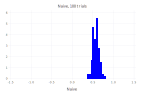

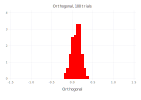

In [5]:
B = 100
Naive = zeros(B)
Orthogonal = zeros(B)

for i in 1:B
    n = 1000
    p = 100
    beta = 1 ./ (1:p).^2
    gamma = 1 ./ (1:p).^2

    X = rand(Normal(0,1),n,p)
    D = X * (gamma) + (rand(Normal(0,1),n,1)/4)
    Y = 10*D + X * (beta) + rand(Normal(0,1),n,1)
    
    X = DataFrame(X, :auto)
    D = DataFrame(D, ["D"])
    X1 = hcat(D,X)

    Y = DataFrame(Y, ["Y"])
    
    ## NAIVE
    model1=rlasso_arg( X1, Y ,nothing, true, true, true, false, false, 
                    nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, false, Inf, true )
    
    coef1 = rlasso(model1)["coefficients"][3:102,2]
    SX_IDs = findall(rlasso(model1)["coefficients"][3:102,2] .!= 0 )

    if (sum(coef1[SX_IDs,:])==0) 
        Y1 = hcat(Y,D)
        Naive[i] = coef(lm(@formula(Y ~ D), Y1))[2] - 10
    end

    if (sum(coef1[SX_IDs,:])>0) 
        Xi = DataFrame(X[:,SX_IDs])
        Y2 = hcat(Y,D,Xi)
        Naive[i] = coef(lm(@formula(Y ~ D + x1 ), Y2))[2] - 10
    end

    ## ORTHOGONAL LEARNING
    model2 =rlasso_arg( X, Y ,nothing, false, true, true, false, false, 
                        nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )
    model3 =rlasso_arg( X, D ,nothing, false, true, true, false, false, 
                        nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )

    resY = rlasso(model2)["residuals"]
    resD = rlasso(model3)["residuals"]
    Y3=DataFrame(hcat(resY,resD),["resY","resD"])
    Orthogonal[i]= coef(lm(@formula(resY ~ resD), Y3))[2] - 10

end


results = DataFrame(hcat(Naive,Orthogonal),["Naive","Orthogonal"])

display(Gadfly.plot(results, Coord.cartesian(xmin=-1.5, xmax=1.5),
    layer(x = "Naive", Geom.histogram(bincount=10, density=true),
    color=[colorant"blue"]),
    Guide.title("Naive, 100 trials")
))

display(Gadfly.plot(results, Coord.cartesian(xmin=-1.5, xmax=1.5),
    layer(x = "Orthogonal", Geom.histogram(bincount=10, density=true),
    color=[colorant"red"]),
    Guide.title("Orthogonal, 100 trials")
))

# Simulation Design 2

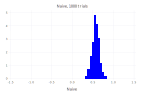

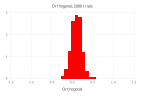

In [6]:
B = 1000
Naive = zeros(B)
Orthogonal = zeros(B)

for i in 1:B
    n = 1000
    p = 100
    beta = 1 ./ (1:p).^2
    gamma = 1 ./ (1:p).^2

    X = rand(Normal(0,1),n,p)
    D = X * (gamma) + (rand(Normal(0,1),n,1)/4)
    Y = 10*D + X * (beta) + rand(Normal(0,1),n,1)
    
    X = DataFrame(X, :auto)
    D = DataFrame(D, ["D"])
    X1 = hcat(D,X)

    Y = DataFrame(Y, ["Y"])
    
    ## NAIVE
    model1=rlasso_arg( X1, Y ,nothing, true, true, true, false, false, 
                    nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, false, Inf, true )
    
    coef1 = rlasso(model1)["coefficients"][3:102,2]
    SX_IDs = findall(rlasso(model1)["coefficients"][3:102,2] .!= 0 )

    if (sum(coef1[SX_IDs,:])==0) 
        Y1 = hcat(Y,D)
        Naive[i] = coef(lm(@formula(Y ~ D), Y1))[2] - 10
    end

    if (sum(coef1[SX_IDs,:])>0) 
        Xi = DataFrame(X[:,SX_IDs])
        Y2 = hcat(Y,D,Xi)
        Naive[i] = coef(lm(@formula(Y ~ D + x1 ), Y2))[2] - 10
    end

    ## ORTHOGONAL LEARNING
    model2 =rlasso_arg( X, Y ,nothing, false, true, true, false, false, 
                        nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )
    model3 =rlasso_arg( X, D ,nothing, false, true, true, false, false, 
                        nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )

    resY = rlasso(model2)["residuals"]
    resD = rlasso(model3)["residuals"]
    Y3=DataFrame(hcat(resY,resD),["resY","resD"])
    Orthogonal[i]= coef(lm(@formula(resY ~ resD), Y3))[2] - 10

end


results = DataFrame(hcat(Naive,Orthogonal),["Naive","Orthogonal"])

display(Gadfly.plot(results, Coord.cartesian(xmin=-1.5, xmax=1.5),
    layer(x = "Naive", Geom.histogram(bincount=10, density=true),
    color=[colorant"blue"]),
    Guide.title("Naive, 1000 trials")
))

display(Gadfly.plot(results, Coord.cartesian(xmin=-1.5, xmax=1.5),
    layer(x = "Orthogonal", Geom.histogram(bincount=10, density=true),
    color=[colorant"red"]),
    Guide.title("Orthogonal, 1000 trials")
))

# Simulation Design 3

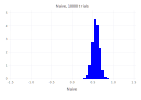

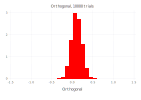

In [7]:
B = 10000
Naive = zeros(B)
Orthogonal = zeros(B)

for i in 1:B
    n = 1000
    p = 100
    beta = 1 ./ (1:p).^2
    gamma = 1 ./ (1:p).^2

    X = rand(Normal(0,1),n,p)
    D = X * (gamma) + (rand(Normal(0,1),n,1)/4)
    Y = 10*D + X * (beta) + rand(Normal(0,1),n,1)
    
    X = DataFrame(X, :auto)
    D = DataFrame(D, ["D"])
    X1 = hcat(D,X)

    Y = DataFrame(Y, ["Y"])
    
    ## NAIVE
    model1=rlasso_arg( X1, Y ,nothing, true, true, true, false, false, 
                    nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, false, Inf, true )
    
    coef1 = rlasso(model1)["coefficients"][3:102,2]
    SX_IDs = findall(rlasso(model1)["coefficients"][3:102,2] .!= 0 )

    if (sum(coef1[SX_IDs,:])==0) 
        Y1 = hcat(Y,D)
        Naive[i] = coef(lm(@formula(Y ~ D), Y1))[2] - 10
    end

    if (sum(coef1[SX_IDs,:])>0) 
        Xi = DataFrame(X[:,SX_IDs])
        Y2 = hcat(Y,D,Xi)
        Naive[i] = coef(lm(@formula(Y ~ D + x1 ), Y2))[2] - 10
    end

    ## ORTHOGONAL LEARNING
    model2 =rlasso_arg( X, Y ,nothing, false, true, true, false, false, 
                        nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )
    model3 =rlasso_arg( X, D ,nothing, false, true, true, false, false, 
                        nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )

    resY = rlasso(model2)["residuals"]
    resD = rlasso(model3)["residuals"]
    Y3=DataFrame(hcat(resY,resD),["resY","resD"])
    Orthogonal[i]= coef(lm(@formula(resY ~ resD), Y3))[2] - 10

end


results = DataFrame(hcat(Naive,Orthogonal),["Naive","Orthogonal"])

display(Gadfly.plot(results, Coord.cartesian(xmin=-1.5, xmax=1.5),
    layer(x = "Naive", Geom.histogram(bincount=10, density=true),
    color=[colorant"blue"]),
    Guide.title("Naive, 10000 trials")
))

display(Gadfly.plot(results, Coord.cartesian(xmin=-1.5, xmax=1.5),
    layer(x = "Orthogonal", Geom.histogram(bincount=10, density=true),
    color=[colorant"red"]),
    Guide.title("Orthogonal, 10000 trials")
))

# Interpretation

The distribution of the histograms is different because they are grouped at various points. When B, what is the number of trials, is higher, the distribution is bigger. Also, the orthogonal should be centered in zero and the Naive should be centered in numbers higher than zero. The last one is biased to the right.

The econometric explanation is based on the approach to data modeling. For the orthogonal distribution, it is assumed that the features (variables) are orthogonal to each other, meaning that they are not correlated. When the errors are orthogonal to each other, it means that they are not correlated and that there is no systematic bias in the relationship between the dependent variable and the dependent variables. This is desirable because it implies that the regression model effectively captures the relationship between variables without additional bias. Zero-centering of the distribution can arise due to the way the model is specified, such as including an intercept or by standardizing variables. On the other hand, for the Naïve distribution, the bias to the right may arise from the nature of the data and the way the conditional probabilities of the variables are modeled. This could be related to the distribution of errors in a regression model. If errors have an asymmetric distribution, such as a right-weighted (positively biased) tail distribution, this can affect how relationships between variables are modeled.

# Parallel computing

Using parallel computing, the running time is lower. The multiprocessing module allows you to create multiple child processes, each of which can execute code independently. These processes can take advantage of the multiple CPU cores available on your machine, resulting in workload distribution and, in many cases, a significant reduction in execution time.. For example (B=100)

Without using parallel computing, for the simulation design 1, the running time is 5 minutes

In [8]:
--Threads 2
if Rhreads.nthreads() ==1
    error("You forgot")

t_start = time()

B = 100
Naive = zeros(B)
Orthogonal = zeros(B)

for i in 1:B
    n = 1000
    p = 100
    beta = 1 ./ (1:p).^2
    gamma = 1 ./ (1:p).^2

    X = rand(Normal(0,1),n,p)
    D = X * (gamma) + (rand(Normal(0,1),n,1)/4)
    Y = 10*D + X * (beta) + rand(Normal(0,1),n,1)
    
    X = DataFrame(X, :auto)
    D = DataFrame(D, ["D"])
    X1 = hcat(D,X)

    Y = DataFrame(Y, ["Y"])
    
    ## NAIVE
    model1=rlasso_arg( X1, Y ,nothing, true, true, true, false, false, 
                    nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, false, Inf, true )
    
    coef1 = rlasso(model1)["coefficients"][3:102,2]
    SX_IDs = findall(rlasso(model1)["coefficients"][3:102,2] .!= 0 )

    if (sum(coef1[SX_IDs,:])==0) 
        Y1 = hcat(Y,D)
        Naive[i] = coef(lm(@formula(Y ~ D), Y1))[2] - 10
    end

    if (sum(coef1[SX_IDs,:])>0) 
        Xi = DataFrame(X[:,SX_IDs])
        Y2 = hcat(Y,D,Xi)
        Naive[i] = coef(lm(@formula(Y ~ D + x1 ), Y2))[2] - 10
    end

    ## ORTHOGONAL LEARNING
    model2 =rlasso_arg( X, Y ,nothing, false, true, true, false, false, 
                        nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )
    model3 =rlasso_arg( X, D ,nothing, false, true, true, false, false, 
                        nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )

    resY = rlasso(model2)["residuals"]
    resD = rlasso(model3)["residuals"]
    Y3=DataFrame(hcat(resY,resD),["resY","resD"])
    Orthogonal[i]= coef(lm(@formula(resY ~ resD), Y3))[2] - 10

end


results = DataFrame(hcat(Naive,Orthogonal),["Naive","Orthogonal"])

display(Gadfly.plot(results, Coord.cartesian(xmin=-1.5, xmax=1.5),
    layer(x = "Naive", Geom.histogram(bincount=10, density=true),
    color=[colorant"blue"]),
    Guide.title("Naive, 100 trials")
))

display(Gadfly.plot(results, Coord.cartesian(xmin=-1.5, xmax=1.5),
    layer(x = "Orthogonal", Geom.histogram(bincount=10, density=true),
    color=[colorant"red"]),
    Guide.title("Orthogonal, 100 trials")
))

LoadError: ParseError:
[90m# Error @ [0;0m]8;;file://C:/Users/VICTOR/Downloads/In[8]#1:1\[90mIn[8]:1:1[0;0m]8;;\
[48;2;120;70;70m--[0;0mThreads 2
[90m└┘ ── [0;0m[91mnot a unary operator[0;0m